In [102]:
#@title imports
import os
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import colormaps
import numpy as np
import seaborn as sns
import statsmodels.formula.api as smf
from statsmodels.nonparametric.smoothers_lowess import lowess
import statsmodels.api as sm
from scipy.stats import linregress

In [103]:
#@title datasetManagement

def load_data(path):
    df = pd.read_csv(path)
    return df

def convert_temperature(df):
    df['temperature'] = df['temperature'].str.replace('C', '').astype(float)
    return df

def calculate_time_metrics(df, fps):
    df['flip_start_time'] = df['start_frame'] / fps
    df['flip_end_time'] = df['end_frame'] / fps
    df['total_duration_seconds'] = df['total_frames'] / fps
    return df

def subset_data(df, t0, t1):
    df_filtered = df[
        (df['flip_start_time'] >= t0) &
        (df['flip_start_time'] <= t1)
    ].copy()
    return df_filtered

def calculate_cumulative_flips(df):
    df_sorted = df.sort_values(by=['experiment_code', 'star_id', 'flip_start_time'])
    df_sorted['cumulative_flip_count'] = df_sorted.groupby(['experiment_code', 'star_id']).cumcount() + 1
    return df_sorted

def get_changes_in_average_duration_between_experiment_by_id_and_t0_t1 (df, t0, t1):
    """
    Calculate average flip durations for W1 and W2 weeks by star ID and temperature,
    as well as the change in average duration between weeks, but only for flips that
    start between t0 and t1 minutes.

    Parameters:
        df (pd.DataFrame): Input dataframe with columns 'star_id', 'week', 'temperature',
                           'duration_seconds', 'flip_start_time'
        t0 (float or int): Start time in minutes
        t1 (float or int): End time in minutes

    Returns:
        rate_dict (dict): Dictionary of average durations by temperature across stars
        change_in_rate_dict (dict): Dictionary of changes in average durations for transitions
    """

    # Convert t0, t1 to seconds
    if t0 is not None:
        t0_seconds = t0 * 60
    if t1 is not None:
        t1_seconds = t1 * 60

    unique_ids = df['star_id'].unique()
    # unique_experiments = df['experiment_code'].unique() # not used directly

    rate_dict = {'12': [], '14.5': [], '17': []}
    change_in_rate_dict = {'12->12': [], '12->14.5': [], '12->17': []}

    for star_id in unique_ids:
        tmp = df[df['star_id'] == star_id]

        # Subset by time window for this star
        if t0 is not None:
            tmp = tmp[(tmp['flip_start_time'] >= t0_seconds)]
        elif t1 is not None:
            tmp = tmp[(tmp['flip_start_time'] <= t1_seconds)]
        
        tmp_weeks = tmp['week'].unique()

        avg_flip_duration1 = np.nan
        avg_flip_duration2 = np.nan
        temp1 = np.nan
        temp2 = np.nan

        # If W1 data exist within t0-t1 window
        if 'W1' in tmp_weeks:
            tmpw1 = tmp[tmp['week'] == 'W1']
            if not tmpw1.empty:
                temp1 = tmpw1['temperature'].values[0]
                avg_flip_duration1 = tmpw1['duration_seconds'].mean()
                if temp1 == 12:
                    rate_dict['12'].append(avg_flip_duration1)
                elif temp1 == 14.5:
                    rate_dict['14.5'].append(avg_flip_duration1)
                elif temp1 == 17:
                    rate_dict['17'].append(avg_flip_duration1)
                else:
                    print('error in W1')

        # If W2 data exist within t0-t1 window
        if 'W2' in tmp_weeks:
            tmpw2 = tmp[tmp['week'] == 'W2']
            if not tmpw2.empty:
                temp2 = tmpw2['temperature'].values[0]
                avg_flip_duration2 = tmpw2['duration_seconds'].mean()
                if temp2 == 12:
                    rate_dict['12'].append(avg_flip_duration2)
                elif temp2 == 14.5:
                    rate_dict['14.5'].append(avg_flip_duration2)
                elif temp2 == 17:
                    rate_dict['17'].append(avg_flip_duration2)
                else:
                    print('error in W2')

        # If both W1 and W2 data are present and not NaN
        if 'W1' in tmp_weeks and 'W2' in tmp_weeks and not np.isnan(avg_flip_duration1) and not np.isnan(avg_flip_duration2):
            diff_avg_flip_duration = avg_flip_duration2 - avg_flip_duration1
            if temp1 == 12 and temp2 == 12:
                change_in_rate_dict['12->12'].append(diff_avg_flip_duration)
            elif temp1 == 12 and temp2 == 14.5:
                change_in_rate_dict['12->14.5'].append(diff_avg_flip_duration)
            elif temp1 == 12 and temp2 == 17:
                change_in_rate_dict['12->17'].append(diff_avg_flip_duration)
            else:
                print('error in transition')

    return rate_dict, change_in_rate_dict

In [104]:
#@title rawDataPlottingFunctions

def loess_with_ci(x, y, frac=0.3, n_boot=1000, ci=95):
    """
    Compute LOESS fit and bootstrap confidence intervals.

    Parameters:
        x (array): 1D array of x values
        y (array): 1D array of y values
        frac (float): Smoothing parameter for lowess (fraction of points)
        n_boot (int): Number of bootstrap iterations
        ci (float): Confidence interval percentage

    Returns:
        x_fit (array): Sorted x values used for LOESS prediction
        y_fit (array): LOESS-smoothed values corresponding to x_fit
        y_lower (array): Lower CI bound at x_fit
        y_upper (array): Upper CI bound at x_fit
    """
    # Sort data by x to ensure a smooth fit
    order = np.argsort(x)
    x_sorted = x[order]
    y_sorted = y[order]

    # Compute initial LOESS
    loess_result = lowess(y_sorted, x_sorted, frac=frac, return_sorted=True)
    x_fit = loess_result[:, 0]
    y_fit = loess_result[:, 1]

    # Bootstrap to get CI
    boot_preds = []
    n = len(x_sorted)
    for _ in range(n_boot):
        # Resample indices with replacement
        idx = np.random.randint(0, n, n)
        x_boot = x_sorted[idx]
        y_boot = y_sorted[idx]

        # Fit LOESS on bootstrap sample
        boot_loess = lowess(y_boot, x_boot, frac=frac, return_sorted=True)

        # Interpolate predictions at x_fit for consistent comparisons
        # np.interp requires x_boot to be sorted. Ensure it's sorted first.
        boot_x_order = np.argsort(boot_loess[:, 0])
        boot_xs = boot_loess[boot_x_order, 0]
        boot_ys = boot_loess[boot_x_order, 1]

        y_boot_pred = np.interp(x_fit, boot_xs, boot_ys)
        boot_preds.append(y_boot_pred)

    boot_preds = np.array(boot_preds)
    lower_bound = (100 - ci) / 2
    upper_bound = 100 - lower_bound
    y_lower = np.percentile(boot_preds, lower_bound, axis=0)
    y_upper = np.percentile(boot_preds, upper_bound, axis=0)

    return x_fit, y_fit, y_lower, y_upper



def plot_loess_smoothing_with_ci(
    df, t0, t1, plot_dir,
    frac=0.3, n_boot=100, ci=95,
    # Plotting parameters
    figsize=(6,4),
    scatter_alpha=0.3,
    scatter_size=20,
    line_width=2.5,
    ci_alpha=0.2,
    vertical_line_style='--',
    vertical_line_width=2,
    vertical_line_alpha=0.7,
    cmap='Grays',
    grid_linestyle='--',
    grid_linewidth=0.5,
    grid_alpha=0.7,
    xlabel='Time in Experiment (min)',
    ylabel='Flip Duration (sec)',
    title='LOESS-Smoothed Flip Duration by Temperature',
    title_fontsize=12,
    xlabel_fontsize=12,
    ylabel_fontsize=12,
    legend_title='Temperature (°C)',
    legend_title_fontsize=12,
    legend_fontsize=12,
    dpi=300,
    # Text annotations for t0 and t1
    text_offset_x=0.1,   # Horizontal offset from the vertical line
    text_offset_y=0.05,  # Vertical offset as a fraction of y-range
    text_fontsize=12,
    # Colormap range parameters to avoid white lines
    cmap_min=0.4,
    cmap_max=0.9
):
    """
    Plot flip duration as a function of time (in minutes) using LOESS smoothing with bootstrap CIs.
    Vertical lines indicating t0 and t1 are drawn, and annotated directly on the plot.
    The Grays colormap is used, and the range is restricted to avoid too-white lines.

    Parameters:
        df (pd.DataFrame): Dataframe with 'flip_start_time', 'duration_seconds', 'temperature'
        t0 (float): Start cut in minutes
        t1 (float): End cut in minutes
        plot_dir (str): Directory to save the plot
        frac (float): LOESS fraction parameter
        n_boot (int): Number of bootstrap iterations for CI
        ci (float): Confidence interval (e.g., 95 for 95% CI)

        # Plotting parameters:
        figsize (tuple): Size of the figure (width, height)
        scatter_alpha (float): Alpha for scatter points
        scatter_size (int): Size for scatter points
        line_width (float): Line width for LOESS lines
        ci_alpha (float): Alpha for CI fill area
        vertical_line_style (str): Line style for vertical reference lines
        vertical_line_width (float): Line width for vertical reference lines
        vertical_line_alpha (float): Alpha for vertical reference lines
        cmap (str): Colormap name for temperature series
        grid_linestyle (str): Linestyle for grid
        grid_linewidth (float): Line width for grid lines
        grid_alpha (float): Alpha for grid lines
        xlabel (str): X-axis label
        ylabel (str): Y-axis label
        title (str): Plot title
        title_fontsize (int): Font size for title
        xlabel_fontsize (int): Font size for x-axis label
        ylabel_fontsize (int): Font size for y-axis label
        legend_title (str): Title for legend
        legend_title_fontsize (int): Font size for legend title
        legend_fontsize (int): Font size for legend items
        dpi (int): Dots per inch for the saved figure
        text_offset_x (float): Horizontal offset for annotation texts relative to the vertical line
        text_offset_y (float): Vertical offset as a fraction of the y-range for annotation texts
        text_fontsize (int): Font size for annotation texts
        cmap_min (float): Minimum value for colormap range
        cmap_max (float): Maximum value for colormap range

    Returns:
        None
    """
    df = df.copy()
    df['temperature'] = df['temperature'].astype(float)
    df['flip_minute'] = df['flip_start_time'] / 60.0

    unique_temps = sorted(df['temperature'].unique())

    fig, ax = plt.subplots(1, 1, figsize=figsize)

    colormap = colormaps.get_cmap(cmap)
    color_values = np.linspace(cmap_min, cmap_max, len(unique_temps))
    colors = colormap(color_values)

    for temp, color in zip(unique_temps, colors):
        temp_data = df[df['temperature'] == temp]
        x = temp_data['flip_minute'].values
        y = temp_data['duration_seconds'].values

        # Compute LOESS and CI
        x_fit, y_fit, y_lower, y_upper = loess_with_ci(x, y, frac=frac, n_boot=n_boot, ci=ci)

        # Plot scatter
        ax.scatter(x, y, color=color, alpha=scatter_alpha, s=scatter_size)

        # Plot LOESS line
        ax.plot(x_fit, y_fit, color=color, linewidth=line_width, label=f"{temp}°C")

        # Plot CI band
        ax.fill_between(x_fit, y_lower, y_upper, color=color, alpha=ci_alpha)

    # Add vertical lines (without legend entries)
    if t0 is not None:
        ax.axvline(x=t0, color='black', linestyle=vertical_line_style,
                   linewidth=vertical_line_width, alpha=vertical_line_alpha)
    if t1 is not None:
        ax.axvline(x=t1, color='black', linestyle=vertical_line_style,
                   linewidth=vertical_line_width, alpha=vertical_line_alpha)

    # Set labels and title
    ax.set_xlabel(xlabel, fontsize=xlabel_fontsize)
    ax.set_ylabel(ylabel, fontsize=ylabel_fontsize)
    ax.set_title(title, fontsize=title_fontsize, loc='left')
    
    # define xticks and labels
    xticks = np.arange(np.floor(df['flip_minute'].min()), np.ceil(df['flip_minute'].max()) + 1, 1)
    ax.set_xticks(xticks)
    ax.set_xticklabels([f"{int(x)}" for x in xticks])
    
    # Force tick marks to appear and be visible
    ax.tick_params(axis='both', which='major', direction='out', length=3, width=1, colors='black',
                   bottom=True, left=True)

    # Ensure spines are visible and set their color
    for spine in ax.spines.values():
        spine.set_visible(True)
        spine.set_color('black')
        spine.set_linewidth(1)

    # Make sure grid lines do not hide ticks
    ax.set_axisbelow(True)

    # Set grid
    ax.grid(True, which='major', linestyle=grid_linestyle, linewidth=grid_linewidth, alpha=grid_alpha)

    # Show legend
    ax.legend(title=legend_title, title_fontsize=legend_title_fontsize, fontsize=legend_fontsize, frameon=False, loc='upper right')

    # Add text annotations for t0 and t1
    y_min, y_max = ax.get_ylim()
    if t0 is not None:
        ax.text(t0 + text_offset_x,
                y_max - text_offset_y*(y_max - y_min),
                f"t0={t0} min", fontsize=text_fontsize, va='top', ha='left')
    if t1 is not None:
        ax.text(t1 + text_offset_x,
                y_max - text_offset_y*(y_max - y_min),
                f"t1={t1} min", fontsize=text_fontsize, va='top', ha='left')

    path_fig = os.path.join(plot_dir, f'loess_smoothing_t0_{t0}_t1_{t1}.png')

    fig.tight_layout()
    fig.savefig(path_fig, dpi=dpi)
    plt.show()
    plt.close(fig)






In [105]:
#@title outlierDetectionAndVisualization

def find_outliers_iqr(df, duration_col='duration_seconds'):
    """
    Identify outliers in the dataset based on IQR method.
    """
    Q1 = df[duration_col].quantile(0.25)
    Q3 = df[duration_col].quantile(0.75)
    IQR = Q3 - Q1
    
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    outliers = (df[duration_col] < lower_bound) | (df[duration_col] > upper_bound)
    return outliers

def plot_full_distribution_with_outliers_line_two_yaxes(
    df, flip_time_col='flip_start_time', duration_col='duration_seconds',
    outlier_col='is_outlier', plot_dir='.', dpi=300,
    # Plotting parameters
    figsize=(6,4),
    violin_positions=[-2],
    violin_facecolor='gray',
    violin_edgecolor='black',
    violin_alpha=0.7,
    non_outlier_color='lightgray',
    outlier_color='red',
    scatter_size=10,
    scatter_alpha_non_outlier=0.5,
    scatter_alpha_outlier=0.7,
    scatter_edgecolor='white',
    scatter_linewidth=0.5,
    secondary_line_color='black',
    secondary_line_width=2,
    x_left_limit_offset=-3,
    x_right_limit_offset=0.5,
    xtick_distance=1,
    xtick_outlier_label='Flip Rate',
    num_yticks=5,
    duration_ylabel='Flip Duration (sec)',
    outlier_ylabel = r"Outlier Ratio ($\frac{\text{Outliers}}{\text{Samples}}$)",
    title='Outlier Rate Binned by Minute',
    title_fontsize=12,
    xlabel = r"Time Bins ($t_0 < t \leq t_1$)", 
    xlabel_fontsize=12,
    ylabel_fontsize=12,
    legend_loc='upper left',
    legend_fontsize=10,
    legend_title="Points",
    legend_title_fontsize=10,
    grid_linestyle='--',
    grid_alpha=1
):
    """
    Plot the full distribution of durations as a violin at a specified x-position with points overlaid,
    and a line plot of the ratio of outliers by minute on a separate y-axis.
    The durations are normalized to 0->1 for plotting, but displayed starting at 0 up to dur_range.
    The ratio of outliers axis dynamically adjusts to the maximum ratio found, instead of always going to 1.

    Parameters:
        df (pd.DataFrame): DataFrame with 'flip_start_time', 'duration_seconds', 'is_outlier'.
        flip_time_col (str): Column with flip start times in seconds.
        duration_col (str): Column with the duration data.
        outlier_col (str): Column indicating if a point is an outlier (boolean).
        plot_dir (str): Directory to save the figure.
        dpi (int): Dots per inch for saving the figure.

        # Plotting parameters:
        (See function head for details)
    """
    df = df.copy()
    # Convert flip times to minutes and group by minute
    df['flip_minute'] = df[flip_time_col] / 60.0
    df['minute_floor'] = df['flip_minute'].floordiv(1)

    # Compute counts and outliers per bin
    counts_per_bin = df.groupby('minute_floor')[outlier_col].count()
    outliers_per_bin = df.groupby('minute_floor')[outlier_col].sum()

    # Compute ratio of outliers
    outlier_ratio = outliers_per_bin / counts_per_bin

    # Extract durations and outlier info
    all_durations = df[duration_col].values
    non_outliers = df[~df[outlier_col]]
    outliers_df = df[df[outlier_col]]

    # Compute min/max for durations
    dur_min, dur_max = all_durations.min(), all_durations.max()
    dur_range = dur_max - dur_min if (dur_max - dur_min) != 0 else 1

    # Normalize durations to [0,1]
    norm_all_durations = (all_durations - dur_min) / dur_range
    norm_non_outliers = (non_outliers[duration_col].values - dur_min) / dur_range
    norm_outliers = (outliers_df[duration_col].values - dur_min) / dur_range

    fig, ax = plt.subplots(figsize=figsize)

    # Violin for full distribution (normalized)
    parts = ax.violinplot([norm_all_durations], positions=violin_positions, 
                          showmeans=False, showmedians=False, showextrema=False)
    for pc in parts['bodies']:
        pc.set_facecolor(violin_facecolor)
        pc.set_edgecolor(violin_edgecolor)
        pc.set_alpha(violin_alpha)
    
    # Scatter non-outliers (normalized)
    ax.scatter(np.full(len(norm_non_outliers), violin_positions[0]), norm_non_outliers,
               color=non_outlier_color, s=scatter_size, alpha=scatter_alpha_non_outlier,
               edgecolors=scatter_edgecolor, linewidths=scatter_linewidth, label='Non-outliers')
    
    # Scatter outliers (normalized)
    ax.scatter(np.full(len(norm_outliers), violin_positions[0]), norm_outliers,
               color=outlier_color, s=scatter_size, alpha=scatter_alpha_outlier,
               edgecolors=scatter_edgecolor, linewidths=scatter_linewidth, label='Outliers')

    # Secondary axis for outlier ratio
    ax2 = ax.twinx()

    if len(outlier_ratio) > 0:
        # Determine max ratio and set y-limits accordingly
        max_ratio = outlier_ratio.max()
        # Add some padding above the max ratio
        y2max = max_ratio * 1.1 if max_ratio > 0 else 1.0
        ax2.set_ylim(-.005, y2max)
        ax2.plot(outlier_ratio.index, outlier_ratio.values, marker='o', color=secondary_line_color, linewidth=secondary_line_width)
        
        # Update ticks based on actual max ratio
        y2tick_vals = np.linspace(0, y2max, num_yticks)
        y2tick_labels = [f"{val:.2f}" for val in y2tick_vals]
        ax2.set_yticks(y2tick_vals)
        ax2.set_yticklabels(y2tick_labels)
    else:
        # If no data, just default to 0->1
        ax2.set_ylim(0, 1)
        y2tick_vals = np.linspace(0, 1, num_yticks)
        y2tick_labels = [f"{val:.2f}" for val in y2tick_vals]
        ax2.set_yticks(y2tick_vals)
        ax2.set_yticklabels(y2tick_labels)

    # Set x-limits
    if len(outlier_ratio) > 0:
        min_minute = int(outlier_ratio.index.min())
        max_minute = int(outlier_ratio.index.max())
    else:
        min_minute = 0
        max_minute = 10
    
    ax.set_xlim(violin_positions[0] + x_left_limit_offset/4, max_minute + x_right_limit_offset)

    # Define x-ticks
    xticks = [violin_positions[0]] + list(range(min_minute, max_minute+1, xtick_distance))
    xlabels = [xtick_outlier_label] + [str(x) for x in xticks[1:]]
    ax.set_xticks(xticks)
    ax.set_xticklabels(xlabels)
    ax.set_xlabel(xlabel, fontsize=xlabel_fontsize)

    # Set y-ticks for durations (left axis)
    ytick_vals = np.linspace(0, 1, num_yticks)
    ytick_labels = [f"{(y * dur_range):.0f}" for y in ytick_vals]
    ax.set_yticks(ytick_vals)
    ax.set_yticklabels(ytick_labels)
    ax.set_ylabel(duration_ylabel, fontsize=ylabel_fontsize)

    ax2.set_ylabel(outlier_ylabel, fontsize=ylabel_fontsize)

    # Set title
    ax.set_title(title, fontsize=title_fontsize, loc='left')

    ax.grid(True, linestyle=grid_linestyle, alpha=grid_alpha)
    
    # Force tick marks to appear and be visible
    ax.tick_params(axis='both', which='major', direction='out', length=3, width=1, colors='black',
                   bottom=True, left=True)

    # Ensure spines are visible and set their color
    for spine in ax.spines.values():
        spine.set_visible(True)
        spine.set_color('black')
        spine.set_linewidth(1)
        spine.set_alpha(1)
        
    for spine in ax2.spines.values():
        spine.set_visible(True)
        spine.set_color('black')
        spine.set_linewidth(1)
        spine.set_alpha(1)


    # Make sure grid lines do not hide ticks
    ax.set_axisbelow(True)
    
    # make vertical line at x=-1
    ax.axvline(x=-1, color='black', linestyle='-', linewidth=1, alpha=0.7)

    path_fig = os.path.join(plot_dir, 'outlier_rate_by_time_bin.png')
    fig.tight_layout()
    fig.savefig(path_fig, dpi=dpi)
    plt.show()
    plt.close(fig)


In [106]:
#@title visualizeChangesInRate

def plot_change_in_rate_box_jitter(
    change_in_rate_dict,
    # Plotting parameters
    figsize=(6,4),
    box_color='white',
    box_line_color='black',
    box_linewidth=1.5,
    whisker_linewidth=1,
    cap_linewidth=1,
    median_linewidth=2,
    showfliers=False,
    box_width=0.25,
    jitter_width=0.08,
    point_color='black',
    point_alpha=0.7,
    point_size=20,
    point_edgecolor='white',
    point_linewidth=0.5,
    line_color='black',
    line_width=2,
    line_style='-',
    text_fontsize=12,
    text_facecolor='white',
    text_edgecolor='black',
    text_pad=5,
    text_x=0.65,
    text_y=0.95,
    grid_linestyle='--',
    grid_alpha=1,
    tick_direction='out',
    tick_length=3,
    tick_width=1,
    tick_color='black',
    spine_color='black',
    spine_linewidth=1,
    xlabel='Temperature Transition (°C)',
    xlabel_fontsize=12,
    ylabel='$\Delta$ Avg. Flip Duration (sec)',
    ylabel_fontsize=12,
    title='Change in Average Flip Duration by Individuals Across Treatments',
    title_fontsize=12,
    dpi=300,
    plot_dir='.',
    filename='change_in_rate_box_jitter.png'
):
    """
    Plot boxplots for each key in change_in_rate_dict and overlay individual data points with jitter.
    Then fit a linear model using all individual data points:
        '12->12'   -> x=0
        '12->14.5' -> x=2.5
        '12->17'   -> x=5

    Instead of using only category means, all points are used for the regression.
    This gives a better statistical assessment (slope, p-value, R²).

    Parameters:
        change_in_rate_dict (dict): Keys like '12->12', '12->14.5', '12->17' and values as lists of floats.

        # Plotting parameters:
        figsize (tuple): Figure size.
        box_color (str): Face color of the boxplots.
        box_line_color (str): Color of the box and median line edges.
        box_linewidth (float): Line width of the box edges.
        whisker_linewidth (float): Line width of the whiskers.
        cap_linewidth (float): Line width of the caps.
        median_linewidth (float): Line width of the median line.
        showfliers (bool): Whether to show outliers in the boxplot.
        box_width (float): Width of each box in the boxplot.
        jitter_width (float): Horizontal jitter width for scatter points.
        point_color (str): Color for the scatter points.
        point_alpha (float): Transparency for scatter points.
        point_size (int/float): Size of scatter points.
        point_edgecolor (str): Edge color for scatter points.
        point_linewidth (float): Line width for scatter point edges.
        line_color (str): Color of the regression line.
        line_width (float): Width of the regression line.
        line_style (str): Style of the regression line (e.g., '-', '--').
        text_fontsize (int): Font size for the annotation text.
        text_facecolor (str): Background color for the annotation text box.
        text_edgecolor (str): Edge color for the annotation text box.
        text_pad (float): Padding for the annotation text box.
        text_x (float): X position of the annotation text (axes fraction).
        text_y (float): Y position of the annotation text (axes fraction).
        grid_linestyle (str): Linestyle for the grid.
        grid_alpha (float): Alpha for the grid lines.
        tick_direction (str): Direction of the ticks ('in', 'out').
        tick_length (float): Length of tick marks.
        tick_width (float): Width of tick marks.
        tick_color (str): Color of tick marks.
        spine_color (str): Color of the axis spines.
        spine_linewidth (float): Line width of the axis spines.
        xlabel (str): X-axis label.
        ylabel (str): Y-axis label.
        title (str): Plot title.
        dpi (int): Dots per inch for the saved figure.
        plot_dir (str): Directory to save the plot.
        filename (str): File name for the saved plot.

    Returns:
        None
    """
    # Define the mapping from categories to x-values
    category_x_map = {
        '12->12': 0.0,
        '12->14.5': 2.5,
        '12->17': 5.0
    }

    keys = list(change_in_rate_dict.keys())
    # Filter out any empty lists
    filtered_keys = [k for k in keys if len(change_in_rate_dict[k]) > 0]
    data_arrays = [change_in_rate_dict[k] for k in filtered_keys]

    # Create arrays of all x and y points for regression
    x_all = []
    y_all = []

    xticklabels = []
    for k, arr in zip(filtered_keys, data_arrays):
        x_val = category_x_map[k]
        xticklabels.append(k+'\n(n='+str(len(arr))+')')
        for val in arr:
            x_all.append(x_val)
            y_all.append(val)

    x_all = np.array(x_all)
    y_all = np.array(y_all)

    fig, ax = plt.subplots(figsize=figsize)

    # Plot boxplots
    x_positions = [category_x_map[k] for k in filtered_keys]
    bp = ax.boxplot(data_arrays, positions=x_positions, patch_artist=True,
                    widths=box_width, showfliers=showfliers, zorder=1)

    # Customize the boxplots
    for box in bp['boxes']:
        box.set_facecolor(box_color)
        box.set_edgecolor(box_line_color)
        box.set_linewidth(box_linewidth)
    for whisker in bp['whiskers']:
        whisker.set_color(box_line_color)
        whisker.set_linewidth(whisker_linewidth)
    for cap in bp['caps']:
        cap.set_color(box_line_color)
        cap.set_linewidth(cap_linewidth)
    for median_line in bp['medians']:
        median_line.set_color(box_line_color)
        median_line.set_linewidth(median_linewidth)

    # Plot jittered individual points
    for i, arr in enumerate(data_arrays):
        arr = np.array(arr)
        x_jitter = x_positions[i] + (np.random.rand(len(arr)) - 0.5) * jitter_width
        ax.scatter(x_jitter, arr, color=point_color, alpha=point_alpha, s=point_size,
                   edgecolors=point_edgecolor, linewidth=point_linewidth, zorder=3)

    # Perform OLS regression using all individual points
    if len(x_all) > 1:
        X = sm.add_constant(x_all)  # Add intercept
        model = sm.OLS(y_all, X).fit()
        slope = model.params[1]
        intercept = model.params[0]
        p_value = model.pvalues[1]
        r_squared = model.rsquared

        # Plot regression line
        x_line = np.linspace(min(x_all), max(x_all), 100)
        y_line = slope * x_line + intercept
        ax.plot(x_line, y_line, color=line_color, linewidth=line_width, linestyle=line_style, zorder=2)

        # Add text annotation for slope, p-value, R²
        # position text relatively on the axes
        text_str = f"dt/DT: {slope:.2f}\nP: {p_value:.3g}\nR²: {r_squared:.2f}"
        ax.text(text_x, text_y, text_str, transform=ax.transAxes, fontsize=text_fontsize,
                verticalalignment='top', horizontalalignment='left',
                bbox=dict(facecolor=text_facecolor, edgecolor=text_edgecolor, pad=text_pad))

    # Set x-ticks and labels
    ax.set_xticks(x_positions)
    ax.set_xticklabels(xticklabels, rotation=0)
    ax.set_xlabel(xlabel, fontsize=xlabel_fontsize)
    ax.set_ylabel(ylabel, fontsize=ylabel_fontsize)
    ax.set_title(title, fontsize=title_fontsize, loc='left')
    
    # add background line at y=0
    ax.axhline(y=0, color='black', linestyle='-', linewidth=1, alpha=1, zorder=0)

    # Set grid
    ax.grid(True, linestyle=grid_linestyle, alpha=grid_alpha)

    # Tick parameters
    ax.tick_params(axis='both', which='major', direction=tick_direction, length=tick_length,
                   width=tick_width, colors=tick_color, bottom=True, left=True)

    # Spines
    for spine in ax.spines.values():
        spine.set_visible(True)
        spine.set_color(spine_color)
        spine.set_linewidth(spine_linewidth)

    ax.set_axisbelow(True)

    path_fig = os.path.join(plot_dir, filename)
    plt.tight_layout()
    plt.savefig(path_fig, dpi=dpi)
    plt.show()
    plt.close(fig)

In [107]:
#@title loadDataset
path_data = os.path.join('..', 'data', 'sea_star_flip_summary.csv')
plot_dir = os.path.join('..', 'plots')
df = load_data(path_data)
df = convert_temperature(df)
df = calculate_time_metrics(df, fps=2)
df = calculate_cumulative_flips(df)
df = df[df['star_id'] != 'p10'] ## no week 1 data
df = df[df['star_id'] != 'i7'] ## no week 1 data

t0 = 1
t1 = None

print('df.columns\n', df.columns)
print('df.head\n', df.head())
print('df.shape\n', df.shape)

df.columns
 Index(['source_file', 'experiment_code', 'run', 'week', 'temperature',
       'star_id', 'date', 'time', 'flip_number', 'start_frame', 'end_frame',
       'duration_frames', 'duration_seconds', 'seconds_from_first_flip_start',
       'total_frames', 'flip_start_time', 'flip_end_time',
       'total_duration_seconds', 'cumulative_flip_count'],
      dtype='object')
df.head
                                          source_file experiment_code run week  \
0  D:\PycnoStressMonitor\data\cold_box_flips\R1_W...       R1_W1_12C  R1   W1   
1  D:\PycnoStressMonitor\data\cold_box_flips\R1_W...       R1_W1_12C  R1   W1   
2  D:\PycnoStressMonitor\data\cold_box_flips\R1_W...       R1_W1_12C  R1   W1   
3  D:\PycnoStressMonitor\data\cold_box_flips\R1_W...       R1_W1_12C  R1   W1   
4  D:\PycnoStressMonitor\data\cold_box_flips\R1_W...       R1_W1_12C  R1   W1   

   temperature star_id        date      time  flip_number  start_frame  \
0         12.0     i11  2023-11-12  14:51:47       

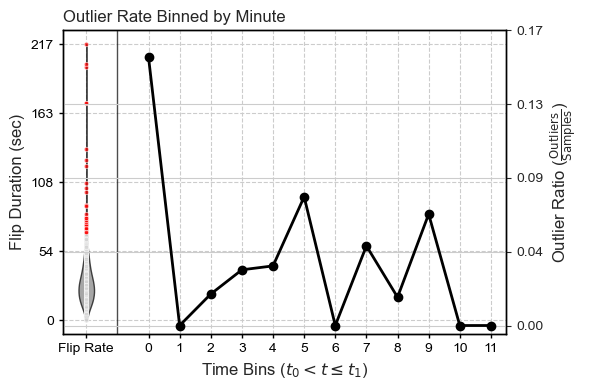

In [108]:
#@title visualizeOutliers
outliers = find_outliers_iqr(df)
df['is_outlier'] = outliers
plot_full_distribution_with_outliers_line_two_yaxes(df, plot_dir=plot_dir)

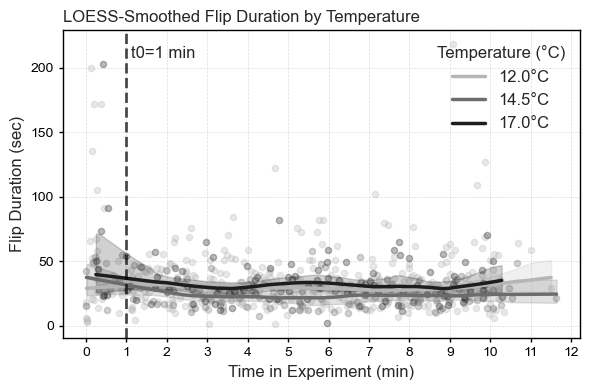

In [109]:
#@title visualizeRaw
plot_loess_smoothing_with_ci(df, t0, t1, plot_dir, frac=0.3, n_boot=100, ci=95)

In [110]:
#@title computeChanges
rate_dict, change_in_rate_dict = get_changes_in_average_duration_between_experiment_by_id_and_t0_t1(df, t0, t1)
print('rate_dict\n', rate_dict)
print('change_in_rate_dict\n', change_in_rate_dict)

rate_dict
 {'12': [np.float64(27.433333333333334), np.float64(23.166666666666668), np.float64(25.95), np.float64(23.38235294117647), np.float64(47.333333333333336), np.float64(26.166666666666668), np.float64(32.333333333333336), np.float64(48.0), np.float64(34.208333333333336), np.float64(35.285714285714285), np.float64(34.72727272727273), np.float64(38.86363636363637), np.float64(19.0), np.float64(36.09090909090909), np.float64(41.1), np.float64(26.714285714285715), np.float64(15.105263157894736), np.float64(21.294117647058822), np.float64(73.08333333333333), np.float64(60.375), np.float64(47.4), np.float64(51.92857142857143), np.float64(37.041666666666664), np.float64(42.31818181818182), np.float64(31.192307692307693), np.float64(33.833333333333336), np.float64(32.67857142857143), np.float64(38.72727272727273)], '14.5': [np.float64(29.366666666666667), np.float64(28.884615384615383), np.float64(24.375), np.float64(19.07894736842105), np.float64(21.88888888888889), np.float64(24.34375

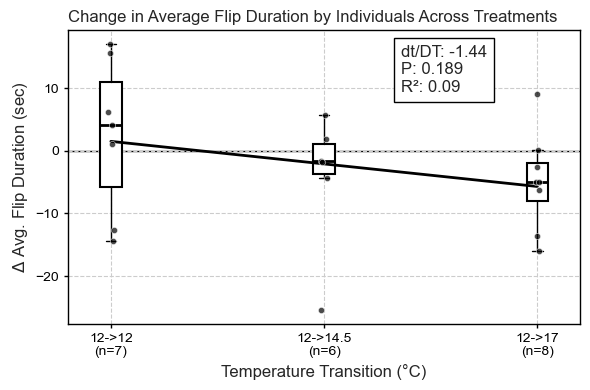

In [111]:
#@title visualizeChanges
plot_change_in_rate_box_jitter(change_in_rate_dict, plot_dir=plot_dir)

In [112]:
#@title diffOfdiffsAnalysisFunctions
"""
Holds all the helper functions needed to run the difference-in-differences (DiD)
analysis. This cell can be placed at the bottom of the notebook and uses any
imports or supporting functions (statsmodels, pandas, etc.) that might already
exist above.

Key Functions Provided:
    1) label_temp_condition(df): 
         - Assigns each star to 'A','B','C' based on the star’s final temperature 
           (week 2).
         - Returns a modified copy of df with a new column 'TempCondition'.
    2) convert_week_to_timepoint(df): 
         - Maps 'W1' -> 1 and 'W2' -> 2 in a new column 'Timepoint'.
    3) run_diff_of_diffs_mixedlm(df, outcome_col='FlipDuration'):
         - Runs a mixed-effects difference-in-differences model using statsmodels.
         - Formula: outcome ~ C(TempCondition) + C(Timepoint) + C(TempCondition):C(Timepoint)
         - Random intercept for star_id.
         - Returns the fitted model object.
"""

import numpy as np
import pandas as pd
import statsmodels.formula.api as smf

def label_temp_condition(df, star_id_col='star_id', week_col='week',
                         temperature_col='temperature'):
    """
    Assign each star to 'A', 'B', or 'C' based on the star's final (week 2) temperature.
    - A: final_temp == 12
    - B: final_temp == 14.5
    - C: final_temp == 17

    Parameters
    ----------
    df : pd.DataFrame
        The input dataframe containing columns for star_id, week, and temperature.
    star_id_col : str
        Column name identifying each star.
    week_col : str
        Column name that denotes the 'week' (e.g., 'W1', 'W2').
    temperature_col : str
        Column name that denotes the temperature (float).

    Returns
    -------
    df_merged : pd.DataFrame
        A copy of the dataframe with a new column 'TempCondition' indicating
        the final group A/B/C for each star.
    """
    # Step 1: Extract each star's final (Week 2) temperature
    df_w2 = df[df[week_col] == 'W2'].groupby(star_id_col)[temperature_col].first()
    df_w2 = df_w2.rename('final_temp').to_frame().reset_index()

    # Step 2: Define a function to map numeric final_temp -> A/B/C
    def map_final_temp_to_condition(t):
        if np.isclose(t, 12.0):
            return 'A'
        elif np.isclose(t, 14.5):
            return 'B'
        elif np.isclose(t, 17.0):
            return 'C'
        else:
            return np.nan  # or raise an error

    df_w2['TempCondition'] = df_w2['final_temp'].apply(map_final_temp_to_condition)

    # Step 3: Merge that info back onto the original dataframe
    df_merged = pd.merge(df.copy(), df_w2[[star_id_col, 'TempCondition']],
                         on=star_id_col, how='left')
    
    return df_merged


def convert_week_to_timepoint(df, week_col='week', new_col='Timepoint'):
    """
    Maps 'W1' -> 1 and 'W2' -> 2 in a new column (default 'Timepoint').

    Parameters
    ----------
    df : pd.DataFrame
        DataFrame with a 'week' column that has values 'W1' or 'W2'.
    week_col : str
        Name of the existing week column.
    new_col : str
        Name of the new column to store numeric timepoint.

    Returns
    -------
    df : pd.DataFrame
        Modified copy of the dataframe with the new numeric timepoint column.
    """
    df = df.copy()
    mapping = {'W1': 1, 'W2': 2}
    df[new_col] = df[week_col].map(mapping)
    return df


def run_diff_of_diffs_mixedlm(df, outcome_col='FlipDuration',
                              star_id_col='star_id',
                              tempcond_col='TempCondition',
                              timepoint_col='Timepoint'):
    """
    Runs the difference-in-differences analysis as a linear mixed-effects model.

    Model formula:
        outcome ~ C(TempCondition) + C(Timepoint) + C(TempCondition):C(Timepoint)
    Random intercept: star_id

    Example interpretation of coefficients:
    --------------------------------------
    - Intercept:        baseline (A group, Timepoint=1)
    - C(TempCondition)[T.B]: difference of B vs. A at baseline
    - C(TempCondition)[T.C]: difference of C vs. A at baseline
    - C(Timepoint)[T.2]: difference from Timepoint=1 to Timepoint=2 for group A
    - C(TempCondition)[T.B]:C(Timepoint)[T.2]: DiD effect for group B vs. A
    - C(TempCondition)[T.C]:C(Timepoint)[T.2]: DiD effect for group C vs. A

    Parameters
    ----------
    df : pd.DataFrame
        Must contain columns for outcome, star ID, temperature condition, timepoint.
    outcome_col : str
        Name of the column with the numeric outcome (e.g., flip duration).
    star_id_col : str
        Name of the column identifying each star.
    tempcond_col : str
        Name of the column indicating the final temperature condition in {A,B,C}.
    timepoint_col : str
        Name of the column indicating timepoint in {1,2}.

    Returns
    -------
    result : statsmodels regression result
        The fitted MixedLM model object from statsmodels.
    """
    df = df.copy()

    # Ensure these columns are categorical (if needed)
    df[tempcond_col] = pd.Categorical(df[tempcond_col], categories=['A','B','C'], ordered=False)
    df[timepoint_col] = pd.Categorical(df[timepoint_col], categories=[1,2], ordered=False)

    # Build the formula
    formula = f"""
    {outcome_col} ~ C({tempcond_col}) + C({timepoint_col}) + C({tempcond_col}):C({timepoint_col})
    """.strip()

    # Fit the mixed-effects model
    md = smf.mixedlm(formula, data=df, groups=df[star_id_col])
    result = md.fit(method='lbfgs', reml=False)  # or reml=True if you prefer
    return result


In [231]:
#@title diffOfdiffResultVisualizationFunctions
"""
Holds one or more functions for visualizing and reporting the results of the
difference-in-differences (DiD) analysis. This cell can be placed at the bottom
of the notebook after the analysis functions.

Key Functions Provided:
    1) print_diff_of_diffs_summary(result):
         - Prints a summary of the fitted DiD model from statsmodels.
         - Optionally, can extract and interpret the key coefficients.
    2) plot_diff_in_diff_estimates(df, result, outcome_col='FlipDuration', 
                                   star_id_col='star_id'):
         - (Optional) Provides a conceptual "difference-in-differences style" plot.
           Aggregates or calculates means by group & timepoint, then plots them.
           Overlays the model’s predicted lines, if desired.
"""

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


def print_diff_of_diffs_summary(result):
    """
    Prints the textual summary of the fitted statsmodels MixedLM or OLS model result.
    Then provides a custom interpretation referencing the actual temperature conditions.
    """

    print("=== Difference-in-Differences Model Summary ===")
    print(result.summary())

    # Custom interpretation block:
    print("\nInterpreting key coefficients (with final temperature groups):")
    print("---------------------------------------------------------------")
    print("  • Intercept:")
    print("      => Baseline (12->12) at Timepoint=1.\n")
    print("  • C(TempCondition)[T.B]:")
    print("      => Baseline difference at Timepoint=1 for 12->14.5 vs. 12->12.\n")
    print("  • C(TempCondition)[T.C]:")
    print("      => Baseline difference at Timepoint=1 for 12->17 vs. 12->12.\n")
    print("  • C(Timepoint)[T.2]:")
    print("      => Difference from Timepoint=1 to Timepoint=2 for 12->12.\n")
    print("  • C(TempCondition)[T.B]:C(Timepoint)[T.2]:")
    print("      => Extra change from T1->T2 (relative to 12->12) for 12->14.5.\n")
    print("  • C(TempCondition)[T.C]:C(Timepoint)[T.2]:")
    print("      => Extra change from T1->T2 (relative to 12->12) for 12->17.\n")

    print("Interpretation logic:\n"
          "--------------------------------------------\n"
          "• If C(TempCondition)[T.B]:C(Timepoint)[T.2] is significantly > 0,\n"
          "    => The 12->14.5 group’s change from T1->T2 is that many units\n"
          "       larger than the 12->12 group’s.\n"
          "• If C(TempCondition)[T.C]:C(Timepoint)[T.2] is significantly > 0,\n"
          "    => The 12->17 group’s change from T1->T2 is that many units\n"
          "       larger than the 12->12 group’s.\n")


def plot_diff_in_diff_estimates(df, 
                                plot_dir,
                                result=None,  
                                outcome_col='duration_seconds',
                                timepoint_col='Timepoint',
                                tempcond_col='TempCondition',
                                star_id_col='star_id',  # Not used here, included for API parity
                                figsize=(5,5)):
    """
    Creates a difference-in-differences style plot *but* with the visual style 
    of raw-data + boxplots + group-means + arrows (as in plot_diff_in_diff_estimates_ols).

    Steps:
      1. Compute group means per (TempCondition, Timepoint).
      2. Plot raw data (with jitter) and overlay boxplots.
      3. Plot star markers for T1/T2 group means, plus an arrow from T1 to T2.
      4. Relabel x-axis with '12 -> 12', '12 -> 14.5', '12 -> 17', matching final TempCondition.
    """

    import numpy as np
    import pandas as pd
    import matplotlib.pyplot as plt

    # 1) Aggregate to get the mean outcome per (TempCondition, Timepoint).
    agg_df = df.groupby([tempcond_col, timepoint_col], as_index=False)[outcome_col].mean()

    # 2) If Timepoint is categorical, convert to numeric for pivoting
    if agg_df[timepoint_col].dtype.name == 'category':
        agg_df[timepoint_col] = agg_df[timepoint_col].cat.codes + 1  # => 1 or 2

    # 3) Pivot to get T1/T2 columns
    pivoted = agg_df.pivot(index=tempcond_col, columns=timepoint_col, values=outcome_col)
    pivoted.columns = [f"T{col}" for col in pivoted.columns]  # rename numeric col -> T1/T2

    # 4) Prepare the figure
    fig, ax = plt.subplots(figsize=figsize)

    # We'll collect each condition: e.g. ['A','B','C']
    conditions = pivoted.index.tolist()
    x_vals = np.arange(len(conditions))  # e.g. [0,1,2]

    ############################################################################
    # Plot raw data + boxplots for T1 vs T2 in each condition
    ############################################################################
    for tempcond in df[tempcond_col].unique():
        for timepoint in df[timepoint_col].unique():
            df_temp = df[(df[tempcond_col] == tempcond) & (df[timepoint_col] == timepoint)]
            # identify the x-position for the condition
            x_val = x_vals[conditions.index(tempcond)]
            # shift left or right depending on timepoint
            if timepoint == 1:
                x_val_shift = x_val - 0.2
            elif timepoint == 2:
                x_val_shift = x_val + 0.2
            else:
                x_val_shift = x_val  # if there's some unexpected timepoint

            # raw y-values
            y_vals = df_temp[outcome_col]

            # jitter the points horizontally so they don't overlap
            x_jittered = x_val_shift + (np.random.rand(len(y_vals)) - 0.5) * 0.2

            # scatter the raw data
            ax.scatter(x_jittered, y_vals, s=2, color='black', alpha=0.25, zorder=1)

            # boxplot overlay
            median_props = dict(color='black', linewidth=1.5)
            ax.boxplot(y_vals, 
                       positions=[x_val_shift],
                       patch_artist=False,   # no filled boxes
                       widths=0.1, 
                       showfliers=False,
                       zorder=2,
                       medianprops=median_props)

    ############################################################################
    # Plot group means with star markers & connect them with arrows
    ############################################################################
    # Pull out T1 and T2 means from pivoted
    t1vals = [pivoted.loc[cond, "T1"] if "T1" in pivoted.columns else np.nan
              for cond in conditions]
    t2vals = [pivoted.loc[cond, "T2"] if "T2" in pivoted.columns else np.nan
              for cond in conditions]

    # Star markers for T1 (blue) & T2 (red)
    ax.scatter(x_vals - 0.2, t1vals, 
               color='#1E88E5', label='12°C Baseline', alpha=1, zorder=5, marker="*", s=100)
    ax.scatter(x_vals + 0.2, t2vals, 
               color='#D82015', label='Test', alpha=1, zorder=5, marker="*", s=100)

    # Draw an arrow from T1 -> T2 for each condition
    for i, cond in enumerate(conditions):
        y1, y2 = t1vals[i], t2vals[i]
        # small offset for a nicer arrow angle
        ax.annotate(
            '', 
            xy=(x_vals[i] + 0.175, y2),   # arrow head
            xytext=(x_vals[i] - 0.15, y1),   # arrow tail
            arrowprops=dict(arrowstyle='->', color='#424242', lw=1.5),
            zorder=4
        )

    ############################################################################
    # Customize x-ticks, grid, spines, labels
    ############################################################################
    # Replace the x-tick labels: A->12->12, B->12->14.5, C->12->17
    label_map = {
        'A': r'$12 \to 12$',
        'B': r'$12 \to 14.5$',
        'C': r'$12 \to 17$',
    }
    new_labels = [label_map.get(cond, cond) for cond in conditions]
    ax.set_xticks(x_vals)
    ax.set_xticklabels(new_labels, rotation=0)
    ax.set_xlabel('Temperature (°C) treatments', fontsize=12)

    ax.set_ylabel('Flip Duration (sec)', fontsize=12)
    ax.set_title("Change in Flip Rates Within Experiments", loc='left', fontsize=12)

    # Turn on a grid
    ax.grid(True, linestyle='--', alpha=0.5, zorder=0)

    # Force tick marks to appear and be visible
    ax.tick_params(axis='both', which='major', direction='out',
                   length=3, width=1, colors='black', bottom=True, left=True)

    # Make spines visible and in black
    for spine in ax.spines.values():
        spine.set_visible(True)
        spine.set_color('black')
        spine.set_linewidth(1)
        spine.set_alpha(1)

    ############################################################################
    # Legend
    ############################################################################
    handles, labels = ax.get_legend_handles_labels()
    # Use a dict to drop duplicates
    unique_legend = dict(zip(labels, handles))
    ax.legend(unique_legend.values(), unique_legend.keys(), 
              frameon=False, loc='best', title='Averages', fontsize=10)

    plt.tight_layout()
    plt.show()
    
    name_fig = 'diff_in_diff_estimates.png'
    path_fig = os.path.join(plot_dir, name_fig)
    fig.savefig(path_fig, dpi=300)




/Users/wlweert/opt/anaconda3/envs/coldBoxFlips/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:1634: UserWarning: Random effects covariance is singular
  warnings.warn(msg)
/Users/wlweert/opt/anaconda3/envs/coldBoxFlips/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:2054: UserWarning: The random effects covariance matrix is singular.
  warnings.warn(_warn_cov_sing)
/Users/wlweert/opt/anaconda3/envs/coldBoxFlips/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/Users/wlweert/opt/anaconda3/envs/coldBoxFlips/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:2245: UserWarning: The random effects covariance matrix is singular.
  warnings.warn(_warn_cov_sing)
/Users/wlweert/opt/anaconda3/envs/coldBoxFlips/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_mo

=== Difference-in-Differences Model Summary ===
                                Mixed Linear Model Regression Results
Model:                          MixedLM              Dependent Variable:              duration_seconds
No. Observations:               544                  Method:                          ML              
No. Groups:                     21                   Scale:                           256.4272        
Min. group size:                14                   Log-Likelihood:                  inf             
Max. group size:                36                   Converged:                       Yes             
Mean group size:                25.9                                                                  
------------------------------------------------------------------------------------------------------
                                        Coef.     Std.Err.     z    P>|z|     [0.025         0.975]   
----------------------------------------------------------

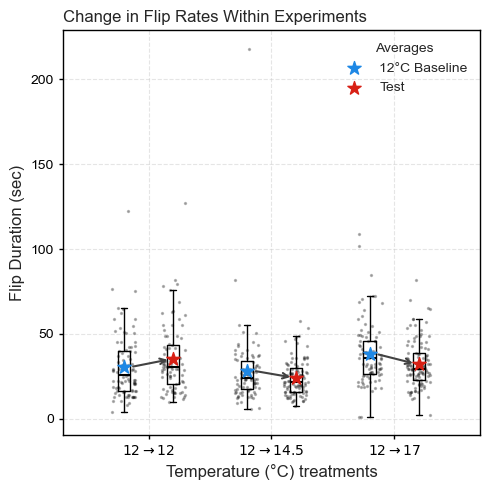

In [232]:
#@title diffOfdiffsAnalysis
"""
Finally, this cell will RUN the analysis and produce outputs,
utilizing the functions from the two cells above.

Process Overview:
1. Load or have your dataframe 'df' in memory with columns:
    ['star_id','week','temperature','FlipDuration', ...]
2. Label each star with final 'TempCondition' => A/B/C
3. Convert 'week' to a numeric 'Timepoint' => 1/2
4. Potentially remove outliers or do any data cleaning
5. Run the difference-in-differences model
6. Print / visualize results
"""

# Example usage code
# NOTE: Adjust paths, column names, or function calls as needed to fit your dataset.

# 1) Create a copy of your DataFrame so we don't mutate the original
df_for_did = df.copy()

# 2) Label the final temperature condition (A/B/C)
df_for_did = label_temp_condition(
    df_for_did,
    star_id_col='star_id',
    week_col='week',
    temperature_col='temperature'
)

# 3) Convert 'week' to numeric 'Timepoint' => 1 or 2
df_for_did = convert_week_to_timepoint(df_for_did, week_col='week', new_col='Timepoint')

# 4) Drop first minute
df_for_did = df_for_did[df_for_did['flip_start_time'] >= 60]

# 5) Run the difference-in-differences model 
#    using duration_seconds as the dependent variable
result = run_diff_of_diffs_mixedlm(
    df_for_did,
    outcome_col='duration_seconds',  # Use the actual column name from your df
    star_id_col='star_id',
    tempcond_col='TempCondition',
    timepoint_col='Timepoint'
)

# 6) Print textual summary
print_diff_of_diffs_summary(result)

# 7) (Optional) Visualize means by condition & timepoint
plot_diff_in_diff_estimates(
    df_for_did,
    plot_dir,
    result,
    outcome_col='duration_seconds',
    timepoint_col='Timepoint',
    tempcond_col='TempCondition',
    star_id_col='star_id'
)


In [115]:
#@title diffOfDiffsOLSanalysisFunctions
"""
Contains the functions needed to run a simpler OLS-based difference-in-differences (DiD) analysis.
We will:
1) label_temp_condition(...) to ensure each star is assigned A/B/C,
2) convert_week_to_timepoint(...) to ensure we have Timepoint=1 or 2,
3) run_diff_of_diffs_ols(...) using statsmodels OLS with robust SEs,
   specifically a difference-in-differences formula.
"""

import numpy as np
import pandas as pd
import statsmodels.formula.api as smf

def label_temp_condition(df, star_id_col='star_id', week_col='week', temperature_col='temperature'):
    """
    Assign each star to 'A'/'B'/'C' based on the star's final (Week 2) temperature.
        - A: final_temp == 12
        - B: final_temp == 14.5
        - C: final_temp == 17

    Returns a new DataFrame with a 'TempCondition' column.
    """
    df_w2 = df[df[week_col] == 'W2'].groupby(star_id_col)[temperature_col].first()
    df_w2 = df_w2.rename('final_temp').reset_index()

    def map_final_temp_to_condition(t):
        if np.isclose(t, 12.0):
            return 'A'
        elif np.isclose(t, 14.5):
            return 'B'
        elif np.isclose(t, 17.0):
            return 'C'
        else:
            return np.nan

    df_w2['TempCondition'] = df_w2['final_temp'].apply(map_final_temp_to_condition)

    df_merged = pd.merge(df.copy(), df_w2[[star_id_col, 'TempCondition']], on=star_id_col, how='left')
    return df_merged


def convert_week_to_timepoint(df, week_col='week', new_col='Timepoint'):
    """
    Maps 'W1' -> 1 and 'W2' -> 2 in a new column.
    """
    df = df.copy()
    mapping = {'W1': 1, 'W2': 2}
    df[new_col] = df[week_col].map(mapping)
    return df


def run_diff_of_diffs_ols(df, outcome_col='duration_seconds',
                          tempcond_col='TempCondition',
                          timepoint_col='Timepoint',
                          robust_cov=True):
    """
    Runs a difference-in-differences OLS model with robust standard errors (if robust_cov=True).

    Formula:
        outcome ~ C(TempCondition) + C(Timepoint) + C(TempCondition):C(Timepoint)

    Example Interpretation:
      - Intercept:  (12->12) at Timepoint=1
      - C(TempCondition)[T.B]: difference from 12->12 at baseline for 12->14.5
      - C(TempCondition)[T.C]: difference from 12->12 at baseline for 12->17
      - C(Timepoint)[T.2]: difference from T=1 to T=2 for 12->12
      - C(TempCondition)[T.B]:C(Timepoint)[T.2]: extra T1->T2 change for 12->14.5 vs. 12->12
      - C(TempCondition)[T.C]:C(Timepoint)[T.2]: extra T1->T2 change for 12->17 vs. 12->12

    Returns the fitted OLS result.
    """
    df = df.copy()
    formula = f"{outcome_col} ~ C({tempcond_col}) + C({timepoint_col}) + C({tempcond_col}):C({timepoint_col})"
    model_ols = smf.ols(formula, data=df).fit(
        cov_type='HC3' if robust_cov else 'nonrobust'
    )
    return model_ols


In [220]:
#@title diffOfDiffsOLSvisualziationFunctions
"""
Contains:
1) print_diff_of_diffs_summary_ols(result): prints the OLS summary plus a 
   custom interpretation referencing 12->12, 12->14.5, 12->17.
2) plot_diff_in_diff_estimates_ols(...): replicates the conceptual "T1 vs T2" 
   plot for each final temperature condition, similar to prior code.
"""

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def print_diff_of_diffs_summary_ols(result):
    """
    Prints an OLS summary, then provides a custom interpretive block
    with references to "12->12", "12->14.5", "12->17".
    """
    print("=== Difference-in-Differences OLS Model Summary ===")
    print(result.summary())
    print("\nInterpreting key coefficients (with final temperature groups):")
    print("---------------------------------------------------------------")
    print("  • Intercept:")
    print("      => Baseline (12->12) at Timepoint=1.\n")
    print("  • C(TempCondition)[T.B]:")
    print("      => Baseline difference at Timepoint=1 for 12->14.5 vs. 12->12.\n")
    print("  • C(TempCondition)[T.C]:")
    print("      => Baseline difference at Timepoint=1 for 12->17 vs. 12->12.\n")
    print("  • C(Timepoint)[T.2]:")
    print("      => Difference from Timepoint=1 to Timepoint=2 for 12->12.\n")
    print("  • C(TempCondition)[T.B]:C(Timepoint)[T.2]:")
    print("      => Extra change from T1->T2 (relative to 12->12) for 12->14.5.\n")
    print("  • C(TempCondition)[T.C]:C(Timepoint)[T.2]:")
    print("      => Extra change from T1->T2 (relative to 12->12) for 12->17.\n")

    print("Interpretation logic:\n"
          "--------------------------------------------\n"
          "• If C(TempCondition)[T.B]:C(Timepoint)[T.2] is significantly > 0,\n"
          "    => 12->14.5’s T1->T2 change exceeds 12->12’s by that coefficient.\n"
          "• If C(TempCondition)[T.C]:C(Timepoint)[T.2] is significantly > 0,\n"
          "    => 12->17’s T1->T2 change exceeds 12->12’s by that coefficient.\n")


def plot_diff_in_diff_estimates_ols(df, result, plot_dir,
                                    outcome_col='duration_seconds',
                                    tempcond_col='TempCondition',
                                    timepoint_col='Timepoint',
                                    figsize=(5,5)):
    """
    Creates a simple group means plot by final temperature condition 
    (A=12->12, B=12->14.5, C=12->17) at T1 vs T2.

    Similar to the previous approach, but we label x-axis with 
    "12 -> 12", "12 -> 14.5", "12 -> 17" directly.
    """

    agg_df = df.groupby([tempcond_col, timepoint_col], as_index=False)[outcome_col].mean()

    # If Timepoint is categorical, convert for pivoting
    if agg_df[timepoint_col].dtype.name == 'category':
        agg_df[timepoint_col] = agg_df[timepoint_col].cat.codes + 1

    pivoted = agg_df.pivot(index=tempcond_col, columns=timepoint_col, values=outcome_col)
    pivoted.columns = [f"T{c}" for c in pivoted.columns]

    fig, ax = plt.subplots(figsize=figsize)
    
    conditions = pivoted.index.tolist()  # e.g. ['A','B','C']
    x_vals = np.arange(len(conditions))
    
    ## for each unique tempcond_col and timepoint_col, plot the raw data
    for tempcond in df[tempcond_col].unique():
        for timepoint in df[timepoint_col].unique():
            df_temp = df[(df[tempcond_col] == tempcond) & (df[timepoint_col] == timepoint)]
            x_val = x_vals[conditions.index(tempcond)]
            if timepoint == 1:
                x_val = x_val - 0.2
            elif timepoint == 2:
                x_val = x_val + 0.2
            else:
                x_val = x_val
                print(f'{timepoint} - timepoint not recognized')
            
            y_val = df_temp['duration_seconds']
            x_vals_tmp = x_val + (np.random.rand(len(y_val)) - 0.5) * 0.2
            ax.scatter(x_vals_tmp, y_val, s=2,
                       color='black', alpha=0.25, zorder=1)
            median_props = dict(color='black', linewidth=1.5)
            ax.boxplot(y_val, positions=[x_val], 
                       patch_artist=False, widths=0.1, showfliers=False, zorder=2,
                       medianprops=median_props)
            

    # Y-values for T1 and T2
    t1vals = [pivoted.loc[cond, "T1"] if "T1" in pivoted.columns else np.nan 
              for cond in conditions]
    t2vals = [pivoted.loc[cond, "T2"] if "T2" in pivoted.columns else np.nan
              for cond in conditions]

    ax.scatter(x_vals - 0.2, t1vals, color='#1E88E5', label='12°C Baseline', alpha=1, zorder=5,
               marker="*")
    ax.scatter(x_vals + 0.2, t2vals, color='#D82015', label='Test', alpha=1, zorder=5,
               marker="*")

    for i, cond in enumerate(conditions):
        y1, y2 = t1vals[i], t2vals[i]
        ax.annotate('', xy=(x_vals[i] - 0.15, y1), xytext=(x_vals[i] + 0.175, y2),
                    arrowprops=dict(arrowstyle='<-', color='#424242', lw=1.5),
                    zorder=4)

    # Replace x-tick labels
    label_map = {
        'A': r'$12 \to 12$',
        'B': r'$12 \to 14.5$',
        'C': r'$12 \to 17$',
    }
    
    ax.grid(True, linestyle='--',
            alpha=0.5, zorder=0)
    
    # Force tick marks to appear and be visible
    ax.tick_params(axis='both', which='major', direction='out', length=3, width=1, colors='black',
                   bottom=True, left=True)

    # Ensure spines are visible and set their color
    for spine in ax.spines.values():
        spine.set_visible(True)
        spine.set_color('black')
        spine.set_linewidth(1)
        spine.set_alpha(1)
    
    new_labels = [label_map.get(cond, cond) for cond in conditions]
    ax.set_xticks(x_vals)
    ax.set_xticklabels(new_labels, rotation=0)
    ax.set_xlabel('Temperature (°C) treatments', fontsize=12)

    ax.set_ylabel('Flip Duration (sec)', fontsize=12)
    ax.set_title("Change in Flip Rates Within Experiments", loc='left', fontsize=12)


    handles, labels = ax.get_legend_handles_labels()
    unique_legend = dict(zip(labels, handles))
    ax.legend(unique_legend.values(), unique_legend.keys(), frameon=False, loc='best', title='Averages', fontsize=10)

    plt.tight_layout()
    plt.show()
    
    name_fig = 'diff_in_diff_estimates_ols.png'
    path_fig = os.path.join(plot_dir, name_fig)
    plt.savefig(path_fig, dpi=300)


=== Difference-in-Differences OLS Model Summary ===
                            OLS Regression Results                            
Dep. Variable:       duration_seconds   R-squared:                       0.061
Model:                            OLS   Adj. R-squared:                  0.052
Method:                 Least Squares   F-statistic:                     10.91
Date:                Sat, 21 Dec 2024   Prob (F-statistic):           5.16e-10
Time:                        13:55:08   Log-Likelihood:                -2341.6
No. Observations:                 544   AIC:                             4695.
Df Residuals:                     538   BIC:                             4721.
Df Model:                           5                                         
Covariance Type:                  HC3                                         
                                              coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------

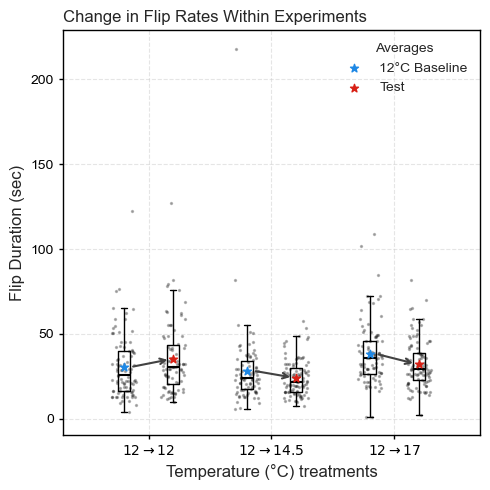

In [221]:
#@title diffOfDiffsOLSSAnalysis
"""
Runs the OLS-based difference-in-differences analysis, then visualizes and reports the results.
"""

# Example usage code:
#  1) Make a copy of your original df
#  2) Label final temperature condition (A/B/C)
#  3) Convert 'week' -> numeric Timepoint
#  4) Possibly remove outliers
#  5) run OLS DiD with robust SE
#  6) report
#  7) visualize

# Below is a template. Adjust column names as needed.
df_ols = df.copy()  # assume you have 'df' from above

# 1) Label final temperature condition
df_ols = label_temp_condition(df_ols,
                              star_id_col='star_id',
                              week_col='week',
                              temperature_col='temperature')

# 2) Convert 'week' -> Timepoint=1 or 2
df_ols = convert_week_to_timepoint(df_ols, week_col='week', new_col='Timepoint')

# 3) Drop first minute
df_ols = df_ols[df_ols['flip_start_time'] >= 60]

# 4) Run OLS DiD
result_ols = run_diff_of_diffs_ols(df_ols,
                                   outcome_col='duration_seconds',
                                   tempcond_col='TempCondition',
                                   timepoint_col='Timepoint',
                                   robust_cov=True)

# 5) Print summary
print_diff_of_diffs_summary_ols(result_ols)

# 6) Plot the group means T1 vs T2
plot_diff_in_diff_estimates_ols(df_ols, result_ols, plot_dir,
                                outcome_col='duration_seconds',
                                tempcond_col='TempCondition',
                                timepoint_col='Timepoint')

